# Imports

In [43]:
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
import pandas as pd
import sys
sys.path.append('../')

from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from qa_evaluation import QA_Evaluator
from question_gen_en import QuestionGenerator

[nltk_data] Downloading package wordnet to C:\Users\Will
[nltk_data]     Blanton\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Helper Functions

In [2]:
def readable_print(text):
    # Replace each period with a period followed by a newline character
    modified_text = text.replace('. ', '.\n')
    print(modified_text)

def meteor_comparison(generated_questions: list[str], dataset_questions: list[str]):
    """
    Compare the generated questions with the dataset questions using METEOR score
    """

    scores = []
    for gq in generated_questions:
        generated_question = word_tokenize(gq.lower())

        # tokenize the questions from the dataset
        ref_questions = [word_tokenize(ref_q.lower()) for ref_q in dataset_questions]

        score = meteor_score(ref_questions, generated_question)

        score = score if score >= .00001 else 0

        scores.append(score)


    average_score = sum(scores) / len(scores)
    return average_score


# Get Questions

In [3]:
articles = pd.read_json("../data/xquad.en.json")

articles = [a for a in articles["data"]]

In [4]:
# crete a list of tuples, each tuple contains the title, context and question

cq_pairs = {}
for a in articles:
    title = a["title"]
    for p in a["paragraphs"]:
        context = p["context"]
        cq_pairs[context] = [(qas["question"], qas["answers"][0]["text"])for qas in p["qas"]]   
            
cq_pairs[list(cq_pairs.keys())[0]]

[('How many points did the Panthers defense surrender?', '308'),
 ('How many career sacks did Jared Allen have?', '136'),
 ('How many tackles did Luke Kuechly register?', '118'),
 ('How many balls did Josh Norman intercept?', 'four'),
 ('Who registered the most sacks on the team this season?', 'Kawann Short'),
 ('How many interceptions are the Panthers defense credited with in 2015?',
  '24'),
 ('Who led the Panthers in sacks?', 'Kawann Short'),
 ('How many Panthers defense players were selected for the Pro Bowl?', 'four'),
 ('How many forced fumbles did Thomas Davis have?', 'four'),
 ('Which player had the most interceptions for the season?', 'Kurt Coleman'),
 ("How many 2015 season interceptions did the Panthers' defense get?", '24'),
 ('Who had five sacks in nine games as a Carolina Panthers starter?',
  'Kony Ealy'),
 ("Who was the Panthers' tackle leader for 2015?", 'Luke Kuechly.'),
 ('How many interceptions did Josh Norman score touchdowns with in 2015?',
  'two.')]

In [5]:
len(cq_pairs)

240

# Test Models for Question Generation

In [6]:
context = list(cq_pairs.keys())[0]
readable_print(context)

The Panthers defense gave up just 308 points, ranking sixth in the league, while also leading the NFL in interceptions with 24 and boasting four Pro Bowl selections.
Pro Bowl defensive tackle Kawann Short led the team in sacks with 11, while also forcing three fumbles and recovering two.
Fellow lineman Mario Addison added 6½ sacks.
The Panthers line also featured veteran defensive end Jared Allen, a 5-time pro bowler who was the NFL's active career sack leader with 136, along with defensive end Kony Ealy, who had 5 sacks in just 9 starts.
Behind them, two of the Panthers three starting linebackers were also selected to play in the Pro Bowl: Thomas Davis and Luke Kuechly.
Davis compiled 5½ sacks, four forced fumbles, and four interceptions, while Kuechly led the team in tackles (118) forced two fumbles, and intercepted four passes of his own.
Carolina's secondary featured Pro Bowl safety Kurt Coleman, who led the team with a career high seven interceptions, while also racking up 88 tack

In [7]:
# generate questions
q_gen = QuestionGenerator()

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can s

In [8]:
# dataset questions
cq_pairs[context]

[('How many points did the Panthers defense surrender?', '308'),
 ('How many career sacks did Jared Allen have?', '136'),
 ('How many tackles did Luke Kuechly register?', '118'),
 ('How many balls did Josh Norman intercept?', 'four'),
 ('Who registered the most sacks on the team this season?', 'Kawann Short'),
 ('How many interceptions are the Panthers defense credited with in 2015?',
  '24'),
 ('Who led the Panthers in sacks?', 'Kawann Short'),
 ('How many Panthers defense players were selected for the Pro Bowl?', 'four'),
 ('How many forced fumbles did Thomas Davis have?', 'four'),
 ('Which player had the most interceptions for the season?', 'Kurt Coleman'),
 ("How many 2015 season interceptions did the Panthers' defense get?", '24'),
 ('Who had five sacks in nine games as a Carolina Panthers starter?',
  'Kony Ealy'),
 ("Who was the Panthers' tackle leader for 2015?", 'Luke Kuechly.'),
 ('How many interceptions did Josh Norman score touchdowns with in 2015?',
  'two.')]

In [9]:
example_qa = cq_pairs[context][0]
example_qa

('How many points did the Panthers defense surrender?', '308')

In [10]:
gen_q = q_gen.generate_question(
    answer=example_qa[1],
    context=context)
gen_q

'How many points did the Panthers defense give up?'

In [11]:
evaluator = QA_Evaluator()

In [12]:
evaluator.answer_question(context, gen_q)

'308'

In [13]:
import random
score_dfs = []

eval_pairs = list(cq_pairs.items())
#eval_pairs = random.sample(list(cq_pairs.items()), 4)

# for each context and answer, generate a question and evaluate it
for context, qas in eval_pairs:
    for question, answer in qas:

        # evaluation metrics to save
        generated_q = q_gen.generate_question(answer, context)
        meteor_q = meteor_comparison([generated_q], [question])
        similarity = evaluator.calculate_similarity(generated_q, question)

        # answer the generated question as part of question evaluation
        generated_a, answer_similarity = evaluator.evaluate_qa_pair(context, generated_q, answer)
        meteor_a = meteor_comparison([generated_a], [answer])

        df = pd.DataFrame({
            "context": [context],
            "answer": [answer],
            "target_q": [question],
            "generated_q": [generated_q],
            "generated_q_answer": [generated_a],
            "exact_match": [int(generated_a.lower() == answer.lower())],
            "q_METEOR_score": [meteor_q],
            "a_METEOR_score": [meteor_a],
            "question_similarity": [similarity],
            "answer_similarity": [answer_similarity]
        })

    score_dfs.append(df)

score_df = pd.concat(score_dfs, axis=0)

Token indices sequence length is longer than the specified maximum sequence length for this model (667 > 512). Running this sequence through the model will result in indexing errors


In [28]:
score_df.reset_index(drop=True, inplace=True)
score_df.head(10)

,context,answer,target_q,generated_q,generated_q_answer,exact_match,q_METEOR_score,a_METEOR_score,question_similarity,answer_similarity
0,"The Panthers defense gave up just 308 points, ...",two.,How many interceptions did Josh Norman score t...,How many fumbles did Luke Kuechly recover?,Two,0,0.272091,0.263158,0.665323,0.891036
1,The Broncos defeated the Pittsburgh Steelers i...,17,How many seconds were left in the game when th...,How many seconds were left on the clock for th...,17 seconds,0,0.507926,0.454545,0.721869,0.564223
2,Peyton Manning became the first quarterback ev...,John Elway,What is the name of the quarterback who was 38...,Who was the oldest quarterback to play in a Su...,Peyton Manning,0,0.429422,0.000000,0.864202,0.470613
3,Six-time Grammy winner and Academy Award nomin...,Marlee Matlin,Who did the sign language of the National Anth...,Who provided the translation of the American S...,Marlee Matlin,1,0.420918,0.937500,0.575758,1.000000
4,"With 4:51 left in regulation, Carolina got the...",Anderson,What is the last name of the player who scored...,Who scored a touchdown on a 2-yard run?,Anderson,1,0.298895,0.500000,0.858088,1.000000
5,"Nearby, in Ogród Saski (the Saxon Garden), the...",Wojciech Bogusławski Theatre,"What theatre was the best example of ""Polish m...","What was the best example of ""Polish monumenta...",Wojciech Bogusawski Theatre,0,0.928079,0.333333,0.980601,0.872758
6,"Their local rivals, Polonia Warsaw, have signi...",disastrous financial situation,Why was Polonia relegated from the country's t...,Why was Polonia relegated from the top flight ...,Their disastrous financial situation.,0,0.856792,0.920139,0.987370,0.802489
7,"Throughout its existence, Warsaw has been a mu...",1944,When were most of the places of religious wors...,In what year did the Warsaw Uprising take place?,1944,1,0.196850,0.500000,0.594869,1.000000
8,The basic unit of territorial division in Pola...,Kraków,In what districts are the registration numbers...,What city does not have entitlements of powiat?,Kraków,1,0.104167,0.500000,0.235350,1.000000
9,Warsaw's first stock exchange was established ...,Polish United Workers' Party,Whose former headquarters was the WSE located ...,What political party was the headquarters of t...,Polish United Workers' Party (PZPR),0,0.180180,0.939623,0.352981,0.881157


In [29]:
score_df

,context,answer,target_q,generated_q,generated_q_answer,exact_match,q_METEOR_score,a_METEOR_score,question_similarity,answer_similarity
0,"The Panthers defense gave up just 308 points, ...",two.,How many interceptions did Josh Norman score t...,How many fumbles did Luke Kuechly recover?,Two,0,0.272091,0.263158,0.665323,0.891036
1,The Broncos defeated the Pittsburgh Steelers i...,17,How many seconds were left in the game when th...,How many seconds were left on the clock for th...,17 seconds,0,0.507926,0.454545,0.721869,0.564223
2,Peyton Manning became the first quarterback ev...,John Elway,What is the name of the quarterback who was 38...,Who was the oldest quarterback to play in a Su...,Peyton Manning,0,0.429422,0.000000,0.864202,0.470613
3,Six-time Grammy winner and Academy Award nomin...,Marlee Matlin,Who did the sign language of the National Anth...,Who provided the translation of the American S...,Marlee Matlin,1,0.420918,0.937500,0.575758,1.000000
4,"With 4:51 left in regulation, Carolina got the...",Anderson,What is the last name of the player who scored...,Who scored a touchdown on a 2-yard run?,Anderson,1,0.298895,0.500000,0.858088,1.000000
...,...,...,...,...,...,...,...,...,...,...
235,Aristotle provided a philosophical discussion ...,unnatural,What did Aristotle refer to forced motion as?,What type of motion did Aristotle believe requ...,Unnatural or forced motion,0,0.453605,0.384615,0.831955,0.679035
236,The development of fundamental theories for fo...,self-consistent unification,What type of physics model did Einstein fail t...,What type of models are physicists trying to d...,self-consistent unification models,0,0.468909,0.892857,0.623114,0.937037
237,"Since then, and so far, general relativity has...",global,In what sense must you be observing the curvat...,What sense of motion is required to observe th...,Global,1,0.730028,0.500000,0.839901,1.000000
238,Through combining the definition of electric c...,electrostatic force,Whatare the electrostatic and magnetic force a...,What is the force that acts on a charge due to...,The electrostatic force,0,0.162602,0.892857,0.570875,0.972408


In [16]:
score_df.describe()

,exact_match,q_METEOR_score,a_METEOR_score,question_similarity,answer_similarity
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,0.516667,0.430163,0.640602,0.696079,0.833880
std,0.500766,0.259689,0.339651,0.218791,0.250456
min,0.000000,0.036496,0.000000,-0.048950,0.035780
25%,0.000000,0.198314,0.416667,0.585123,0.740451
50%,1.000000,0.403451,0.752493,0.724781,1.000000
75%,1.000000,0.573026,0.937500,0.867047,1.000000
max,1.000000,0.999500,0.999898,1.000000,1.000000


In [30]:
worst_semantic = score_df.loc[score_df['question_similarity'].idxmin()]
worst_semantic['question_similarity']

-0.04895007

In [31]:
readable_print(worst_semantic['context'])

 Seamans' establishment of an ad-hoc committee headed by his special technical assistant Nicholas E.
Golovin in July 1961, to recommend a launch vehicle to be used in the Apollo program, represented a turning point in NASA's mission mode decision.
This committee recognized that the chosen mode was an important part of the launch vehicle choice, and recommended in favor of a hybrid EOR-LOR mode.
Its consideration of LOR —as well as Houbolt's ceaseless work— played an important role in publicizing the workability of the approach.
In late 1961 and early 1962, members of the Manned Spacecraft Center began to come around to support LOR, including the newly hired deputy director of the Office of Manned Space Flight, Joseph Shea, who became a champion of LOR.
The engineers at Marshall Space Flight Center (MSFC) took longer to become convinced of its merits, but their conversion was announced by Wernher von Braun at a briefing in June 1962.


In [32]:
worst_semantic['target_q']

'Which NASA location came around last to the idea of the LOR?'

In [33]:
worst_semantic['generated_q']

'What is MSFC?'

In [34]:
worst_semantic['answer']

'Marshall Space Flight Center'

In [35]:
worst_semantic['generated_q_answer']

'Marshall Space Flight Center'

In [36]:
best_score = score_df.loc[score_df['q_METEOR_score'].idxmin()]
readable_print(best_score['context'])

Paleoclimatologists measure the ratio of oxygen-18 and oxygen-16 in the shells and skeletons of marine organisms to determine what the climate was like millions of years ago (see oxygen isotope ratio cycle).
Seawater molecules that contain the lighter isotope, oxygen-16, evaporate at a slightly faster rate than water molecules containing the 12% heavier oxygen-18; this disparity increases at lower temperatures.
During periods of lower global temperatures, snow and rain from that evaporated water tends to be higher in oxygen-16, and the seawater left behind tends to be higher in oxygen-18.
Marine organisms then incorporate more oxygen-18 into their skeletons and shells than they would in a warmer climate.
Paleoclimatologists also directly measure this ratio in the water molecules of ice core samples that are up to several hundreds of thousands of years old.


In [37]:
best_score['generated_q']

'When does the disparity between water molecules and oxygen-16 increase?'

In [38]:
best_score['target_q']

'During what type of climate is oxygen 18 in seawater at higher levels?'

In [39]:
best_score['answer']

'lower global temperatures'

In [40]:
best_score['generated_q_answer']

'At lower temperatures'

# Create plots

<Axes: title={'center': 'METEOR Score Distribution for Generated Questions'}, ylabel='Frequency'>

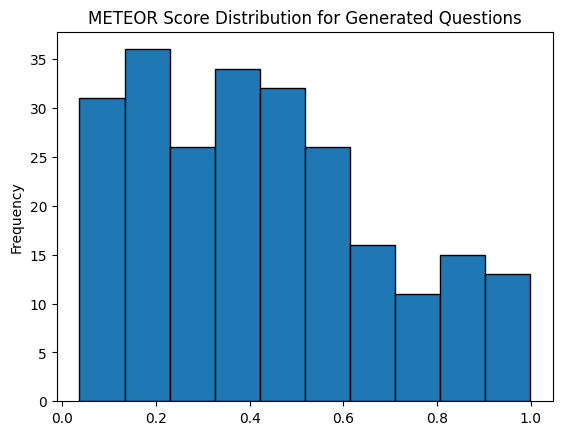

In [47]:
score_df["q_METEOR_score"].plot.hist(edgecolor='black', 
                                     title="METEOR Score Distribution for Generated Questions")

<Axes: title={'center': 'Question Similarity Distribution for Generated Questions'}, ylabel='Frequency'>

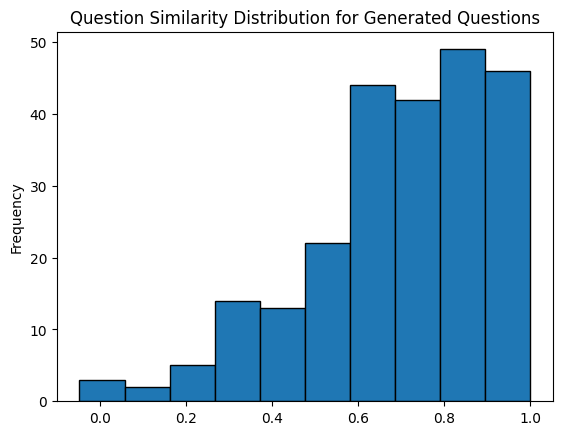

In [48]:
score_df["question_similarity"].plot.hist(edgecolor='black', 
                                          title="Question Similarity Distribution for Generated Questions")

<Axes: title={'center': 'METEOR Score Distribution for Generated Answers'}, ylabel='Frequency'>

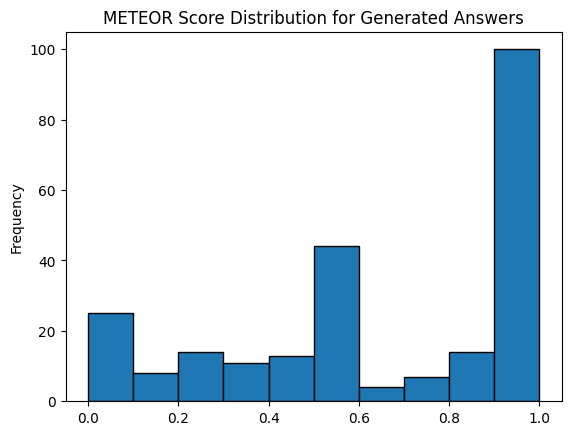

In [55]:
score_df["a_METEOR_score"].plot.hist(edgecolor='black', 
                                     title="METEOR Score Distribution for Generated Answers")

<Axes: title={'center': 'Answer Similarity Distribution for Generated Answers'}, ylabel='Frequency'>

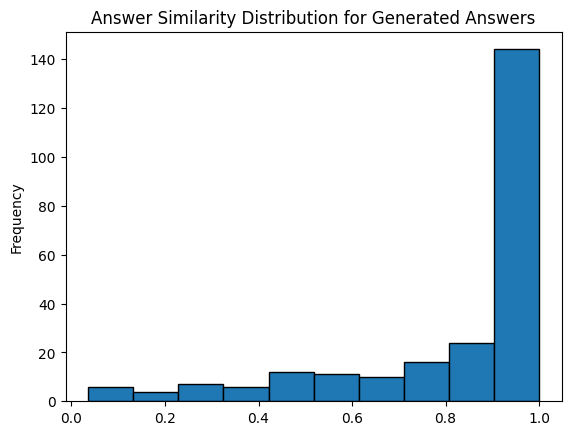

In [58]:
score_df["answer_similarity"].plot.hist(edgecolor='black', 
                                        title="Answer Similarity Distribution for Generated Answers")